# This notebook is a sole place where data analysis is done
### The cell below includes utils function, used mostly for parsing data from .txt file (output of ss for loop) to DataFrame

In [67]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


# ----------------- Parsing utils ----------------
def parse_ss_output(filename):
    '''# Function to parse the ss -tni data from a text file'''
    ESTAB_REGEX = r"ESTAB 0\s+(\d+)"
    # Load data
    with open(filename, "r") as file:
        lines = file.readlines()

    # Data dictionary for storage
    data = {
        "timestamp": [],
        "cwnd": [],
        "bytes_sent": [],
        "rtt": []
    }

    i = 0
    while i < len(lines):
        # Skip to the next "---------"
        if "-----" in lines[i]:
            i += 1  # Skip this line
            if i >= len(lines):
                break
            
            # Parse timestamp
            timestamp_match = re.match(r"^Timestamp: (.+)", lines[i])
            if timestamp_match:
                timestamp = datetime.strptime(timestamp_match.group(1), "%Y-%m-%d %H:%M:%S.%f")
                i += 2  # Move to the next line to check for "ESTAB"

                if i < len(lines) and re.match(ESTAB_REGEX, lines[i]):
                    estab_match = re.match(ESTAB_REGEX, lines[i])
                    recv_q_value = int(estab_match.group(1)) if estab_match else 0
                    if recv_q_value>0:
                        i += 1  # Move to the data line
                        if i < len(lines) and ("bbr" in lines[i] or "cubic" in lines[i]):
                            line = lines[i]

                            # Extract cwnd
                            cwnd_match = re.search(r"cwnd:(\d+)", line)
                            cwnd = int(cwnd_match.group(1)) if cwnd_match else None

                            # Extract bytes_sent
                            bytes_sent_match = re.search(r"bytes_sent:(\d+)", line)
                            bytes_sent = int(bytes_sent_match.group(1)) if bytes_sent_match else None

                            # Extract RTT
                            rtt_match = re.search(r"rtt:(\d+\.\d+)", line)
                            rtt = float(rtt_match.group(1)) if rtt_match else None

                            # Append to the data dictionary
                            data["timestamp"].append(timestamp)
                            data["cwnd"].append(cwnd)
                            data["bytes_sent"].append(bytes_sent)
                            data["rtt"].append(rtt)
                    else :
                        i+=2
                        if i < len(lines) and re.match(ESTAB_REGEX, lines[i]):
                            estab_match = re.match(ESTAB_REGEX, lines[i])
                            recv_q_value = int(estab_match.group(1)) if estab_match else 0

                            if recv_q_value > 0:
                                i += 1  # Move to the data line
                                if i < len(lines) and ("bbr" in lines[i] or "cubic" in lines[i]):
                                    line = lines[i]

                                    # Extract cwnd
                                    cwnd_match = re.search(r"cwnd:(\d+)", line)
                                    cwnd = int(cwnd_match.group(1)) if cwnd_match else None

                                    # Extract bytes_sent
                                    bytes_sent_match = re.search(r"bytes_sent:(\d+)", line)
                                    bytes_sent = int(bytes_sent_match.group(1)) if bytes_sent_match else None

                                    # Extract RTT
                                    rtt_match = re.search(r"rtt:(\d+\.\d+)", line)
                                    rtt = float(rtt_match.group(1)) if rtt_match else None

                                    # Append to the data dictionary
                                    data["timestamp"].append(timestamp)
                                    data["cwnd"].append(cwnd)
                                    data["bytes_sent"].append(bytes_sent)
                                    data["rtt"].append(rtt)
        
        i += 1  # Move to the next line

    df = pd.DataFrame(data)

    # Post-process data
    # Convert timestamp to seconds, starting at second 0
    df["timestamp"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds()

    # Convert bytes_sent to Gbps
    df["GBs_sent"] = df["bytes_sent"] * 8 / 1e9
    return df


# Example Usage
filename = "../data/Cubic_0_BulkTraffic.txt"  # Replace with your file path
# filename = "../data/BBR_0_BulkTraffic.txt"  # Replace with your file path
data = parse_ss_output(filename)
# print(data)



# ----------------- Other utils ----------------

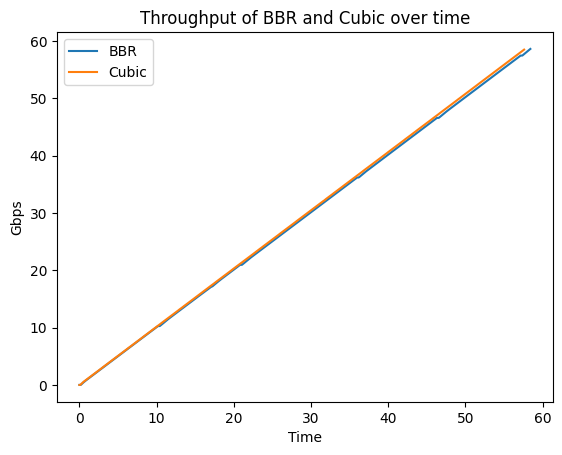

In [63]:






filename1 = "../data/BBR_0_BulkTraffic.txt"
filename2 = "../data/Cubic_0_BulkTraffic.txt"

def graph_compare_throughput_of_two_algorithms_over_time(x_axis_limit_second = False):
    data1 = parse_ss_output(filename1)
    data2 = parse_ss_output(filename2)

    # compare length of datas where bytes_sent is not None
    # if difference of the lengths is bigger than 200, raise error
    DIFF_THRESHOLD = 200
    if abs(len(data1[data1["bytes_sent"].notnull()]) - len(data2[data2["bytes_sent"].notnull()])) > DIFF_THRESHOLD:
        raise ValueError("Most likely something went wrong during data gathering. Please check the data.")
    
    if x_axis_limit_second:
        data1 = data1[data1["timestamp"] <= x_axis_limit_second]
        data2 = data2[data2["timestamp"] <= x_axis_limit_second]
    
    fig, ax = plt.subplots()
    ax.plot(data1["timestamp"], data1["GBs_sent"], label="BBR")
    ax.plot(data2["timestamp"], data2["GBs_sent"], label="Cubic")
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Gbps")
    ax.set_title("Throughput of BBR and Cubic over time")
    ax.legend()

    # cut x-axis to 2 seconds
    # ax.set_xlim(0, 2)

    # fit y-axis to cut data

    
    plt.show()

graph_compare_throughput_of_two_algorithms_over_time()

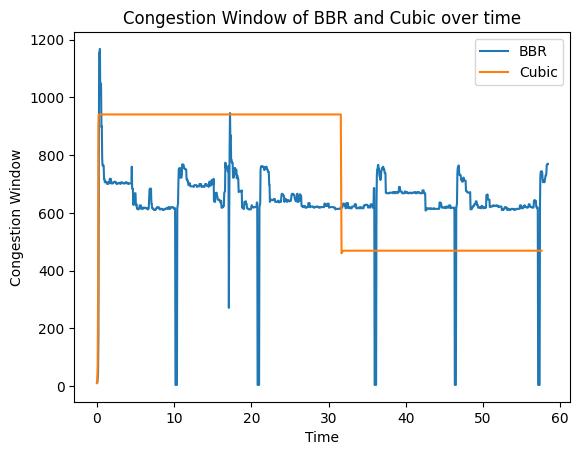

In [64]:
def graph_congestion_window_of_two_algorithms_over_time(x_axis_limit_second = False):
    data1 = parse_ss_output(filename1)
    data2 = parse_ss_output(filename2)

    if x_axis_limit_second:
        data1 = data1[data1["timestamp"] <= x_axis_limit_second]
        data2 = data2[data2["timestamp"] <= x_axis_limit_second]

    fig, ax = plt.subplots()
    ax.plot(data1["timestamp"], data1["cwnd"], label="BBR")
    ax.plot(data2["timestamp"], data2["cwnd"], label="Cubic")

    # drop none values
    data1 = data1.dropna()
    data2 = data2.dropna()
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Congestion Window")
    ax.set_title("Congestion Window of BBR and Cubic over time")
    ax.legend()

    # cut x-axis to 2 seconds

    # fit y-axis to cut data

    
    plt.show()

graph_congestion_window_of_two_algorithms_over_time()

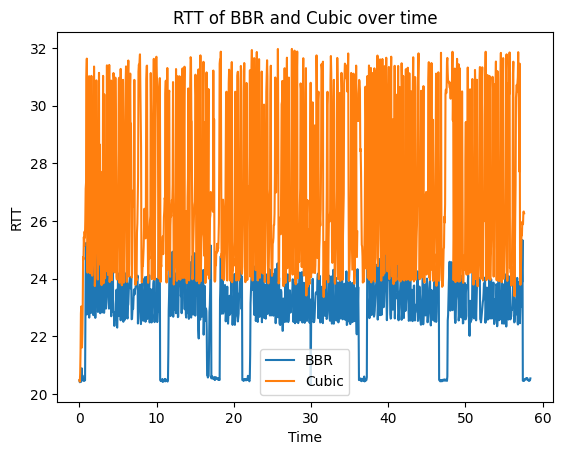

In [65]:
def graph_rtt_of_two_algorithms_over_time(x_axis_limit_second = False):
    data1 = parse_ss_output(filename1)
    data2 = parse_ss_output(filename2)

    if x_axis_limit_second:
        data1 = data1[data1["timestamp"] <= x_axis_limit_second]
        data2 = data2[data2["timestamp"] <= x_axis_limit_second]

    fig, ax = plt.subplots()
    ax.plot(data1["timestamp"], data1["rtt"], label="BBR")
    ax.plot(data2["timestamp"], data2["rtt"], label="Cubic")

    # drop none values
    data1 = data1.dropna()
    data2 = data2.dropna()
    
    ax.set_xlabel("Time")
    ax.set_ylabel("RTT")
    ax.set_title("RTT of BBR and Cubic over time")
    ax.legend()

    # cut x-axis to 2 seconds

    # fit y-axis to cut data

    
    plt.show()

graph_rtt_of_two_algorithms_over_time()